In [27]:
import os
import subprocess

POTENTIAL_NUM = 33
CUTOFF = 5.0
NUM_ATOMS = 8000

path2template = "/home/y1u0d2/result/lammps/scripts/Si/cohesive_energy/template"
path2target = f"/home/y1u0d2/result/lammps/scripts/Si/cohesive_energy/model_{POTENTIAL_NUM}"
path2potential = f"/home/y1u0d2/result/lammps/models/Si/{POTENTIAL_NUM}"

In [28]:
def change_potential_lines(lmp_lines, cutoff, path2potential):
    for i, l in enumerate(lmp_lines):
        if "variable nnpCutoff" in l:
            lmp_lines[i] = f"variable nnpCutoff equal {cutoff}"
        if "variable nnpDir" in l:
            lmp_lines[i] = f'variable nnpDir string "{path2potential}"'
    return lmp_lines


class CohesiveEnergyCalculator():
    def __init__(self, path2template, path2potential, path2target, cutoff=5.0) -> None:
        self.CUTOFF = cutoff
        self.path2template = path2template
        self.path2potential = path2potential
        self.path2target = path2target
        self.NUM_ATOMS = 8000


    def load_template(self):
        # load template
        with open(os.path.join(self.path2template, "single", "in.single"), 'r') as f:
            single_lines = [s.strip() for s in f.readlines()]

        with open(os.path.join(self.path2template, "minimize", "in.minimize"), 'r') as f:
            minimize_lines = [s.strip() for s in f.readlines()]
        
        return single_lines, minimize_lines
    

    def get_lmp_lines(self, single_lines, minimize_lines, path2potential):
        changed_single_lines = change_potential_lines(single_lines, CUTOFF, path2potential)
        changed_minimize_lines = change_potential_lines(minimize_lines, CUTOFF, path2potential)
        return changed_single_lines, changed_minimize_lines
    
    def calculate(self):
        single_lines, minimize_lines = self.load_template()
        changed_single_lines, changed_minimize_lines = self.get_lmp_lines(
            single_lines=single_lines,
            minimize_lines=minimize_lines,
            path2potential=self.path2potential
        )
        # write to file
        path2single = os.path.join(path2target, "single")
        path2minimize = os.path.join(path2target, "minimize")
        os.makedirs(path2single, exist_ok=True)
        os.makedirs(path2minimize, exist_ok=True)
        with open(os.path.join(path2single, "in.single"), 'w') as f:
            f.write("\n".join(changed_single_lines))

        with open(os.path.join(path2minimize, "in.minimize"), 'w') as f:
            f.write("\n".join(changed_minimize_lines))
        
        # run in.single, in.minimize
        if not os.path.exists(os.path.join(path2single, "log.lammps")):
            subprocess.run("lmp -in in.single", cwd=path2single, shell=True)
        if not os.path.exists(os.path.join(path2minimize, "log.lammps")):
            subprocess.run("mpirun -np 16 lmp -in in.minimize", cwd=path2minimize, shell=True)
        
        # read single energy
        with open(os.path.join(path2single, "log.lammps"), 'r') as f:
            log_single_lines = [s.strip() for s in f.readlines()]
        

        energy_idx = None
        for i, l in enumerate(log_single_lines):
            if "TotEng" in l:
                energy_idx = i+1

        single_energy = float(log_single_lines[energy_idx].split()[-2])

        # read minimized energy and number of atoms
        with open(os.path.join(path2minimize, "log.lammps"), 'r') as f:
            log_minimize_lines = [s.strip() for s in f.readlines()]

        for i, l in enumerate(log_minimize_lines):
            if "Energy initial, next-to-last, final" in l:
                minimized_energy = float(log_minimize_lines[i+1].split()[-1])

        print("*" * 50)
        cohesive_energy = (minimized_energy - self.NUM_ATOMS * single_energy) / self.NUM_ATOMS
        print(f"Cohesive energy: {cohesive_energy} eV/atom")
        return cohesive_energy

In [29]:
cohesive_energy_calculator = CohesiveEnergyCalculator(
    path2template=path2template,
    path2potential=path2potential,
    path2target=path2target,
    cutoff=CUTOFF
)
cohesive_energy = cohesive_energy_calculator.calculate()

LAMMPS (23 Jun 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 5.43 5.43 5.43
Created orthogonal box = (0 0 0) to (54.3 54.3 54.3)
  1 by 1 by 1 MPI processor grid
Created 1 atoms
  using lattice units in orthogonal box = (0 0 0) to (54.3 54.3 54.3)
  create_atoms CPU = 0.000 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- ML-HDNNP package: 10.1021/acs.jctc.8b00770
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE


*******************************************************************************

WELCOME TO n²p², A SOFTWARE PACKAGE FOR NEURAL NETWORK POTENTIALS!
------------------------------------------------------------------

n²p² version  (from git): stable_23Jun2022
             (version.h): v2.1.4
--------------------

# 機械特性計算したdirでcohesive energy計算する 

In [15]:
# elastic dirに対してcohesive energyを計算してみる
from glob import glob

CUTOFF = 6.0
NUM_ATOMS = 8000

path2template = "/home/y1u0d2/result/lammps/scripts/Si/cohesive_energy/template"

target_dir_list = glob("/home/y1u0d2/result/n2p2/Si/103/dimer_10x_cutoff_6/elastic/e*")
cohesive_energy_dict = {
    "target_dir": [],
    "cohesive_energy": []
}
for target_dir in target_dir_list:
    path2target, path2potential = target_dir, target_dir
    cohesive_energy_calculator = CohesiveEnergyCalculator(
        path2template=path2template,
        path2potential=path2potential,
        path2target=path2target,
        cutoff=CUTOFF
    )
    cohesive_energy = cohesive_energy_calculator.calculate()
    cohesive_energy_dict["target_dir"].append(target_dir)
    cohesive_energy_dict["cohesive_energy"].append(cohesive_energy)
# path2target = f"/home/y1u0d2/result/lammps/scripts/Si/cohesive_energy/model_{POTENTIAL_NUM}"
# path2potential = f"/home/y1u0d2/result/lammps/models/Si/{POTENTIAL_NUM}"

**************************************************
Cohesive energy: -5.612025489506312 eV/atom
**************************************************
Cohesive energy: -3.7533801711800043 eV/atom
**************************************************
Cohesive energy: -3.708313078384963 eV/atom
**************************************************
Cohesive energy: -3.7013569258275676 eV/atom
**************************************************
Cohesive energy: -4.091746797670028 eV/atom
**************************************************
Cohesive energy: -3.703744247857481 eV/atom
**************************************************
Cohesive energy: -3.8872524860437263 eV/atom
**************************************************
Cohesive energy: -3.9627648742762394 eV/atom
**************************************************
Cohesive energy: -4.064244765491225 eV/atom
**************************************************
Cohesive energy: -4.010548123413697 eV/atom
**********************************************

(-5.0, -2.0)

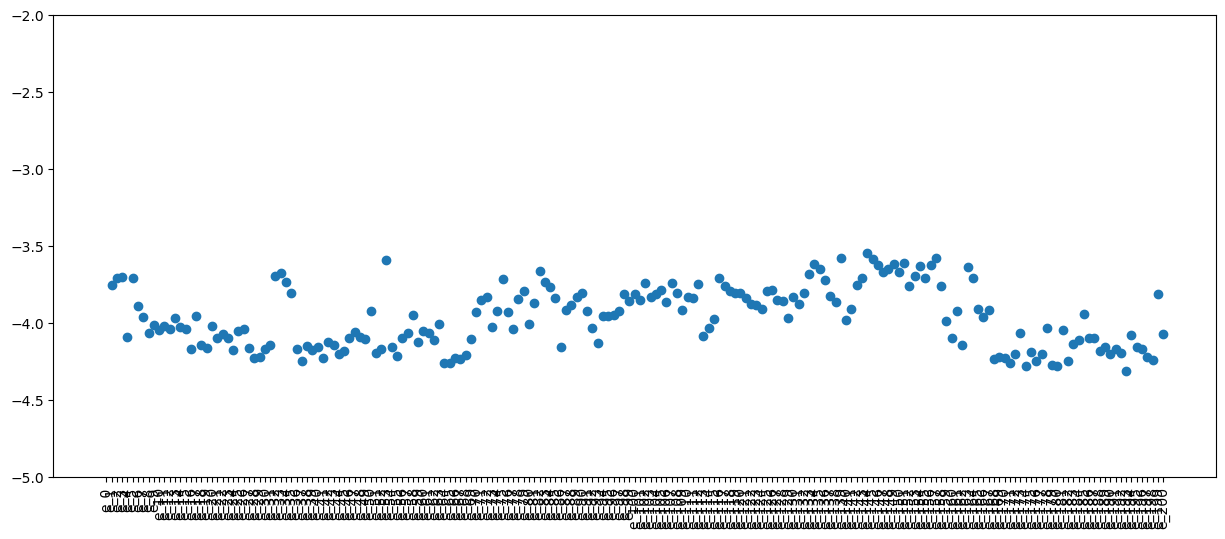

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))
target_dir_basename_list = [os.path.basename(s) for s in cohesive_energy_dict["target_dir"]]
ax.scatter(target_dir_basename_list, cohesive_energy_dict["cohesive_energy"])
# rotate xticks
plt.xticks(rotation=90)
ax.set_ylim(-5, -2)

In [17]:
cohesive_energy_dict["cohesive_energy"][72]

-3.828483527275035

In [20]:
#  最小のcohesive energyを持つものを探す
import numpy as np

min_idx = np.argmin(cohesive_energy_dict["cohesive_energy"][10:])
print(f"min cohesive energy: {cohesive_energy_dict['cohesive_energy'][min_idx]} at {cohesive_energy_dict['target_dir'][min_idx]}")

min cohesive energy: -4.136500519166235 at /home/y1u0d2/result/n2p2/Si/103/dimer_10x_cutoff_6/elastic/e_183


In [4]:
# load ASE Atoms from LAMMPS dump file
from ase.io import read
import os

path2dump = os.path.join("/home/y1u0d2/result/lammps/scripts/Si/cohesive_energy/model_21/minimize/dump.out")
atoms = read(path2dump, format="lammps-dump-text", index=-1)

In [21]:
# get nearest neighbor distance for each atom
from ase.neighborlist import neighbor_list
import numpy as np

cutoff = 6.0
first_atom_idx, second_atom_idx, distance = neighbor_list('ijd', atoms, cutoff)

In [24]:
# groupby first atom index and get minimum distance
from itertools import groupby

grouped = groupby(zip(first_atom_idx, distance), key=lambda x: x[0])
grouped = [(k, min([d for _, d in g])) for k, g in grouped]

# get average of minimum distance
min_distances = np.array([d for _, d in grouped])
print(f"Average of minimum distance: {np.mean(min_distances)}")

Average of minimum distance: 2.351258971274749
